In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torch_geometric.nn import GNNExplainer
from tqdm import tqdm



class GNNExplainerUpdated(GNNExplainer):
    """ 
    https://github.com/rusty1s/pytorch_geometric/blob/master/torch_geometric/nn/models/gnn_explainer.py 
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def explain_graph(self, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.
        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.
        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        with torch.no_grad():
            out = self.model(x=x, edge_index=edge_index, batch=batch, **kwargs)
            log_logits = self.__to_log_prob__(out)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            log_logits = self.__to_log_prob__(out)
            loss = self.__loss__(-1, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()
        return node_feat_mask, edge_mask

In [3]:
from models import DeeperGCN

model = DeeperGCN(5, 256, device)
model.load_state_dict(torch.load('gnn.pt'))
model.eval()

DeeperGCN(
  (layers): ModuleList(
    (0): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=128, out_features=64, bias=True)
    )
    (2): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=64, out_features=32, bias=True)
    )
    (3): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=32, out_features=16, bias=True)
    )
    (4): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=16, out_features=8, bias=True)
    )
  )
  (in_encoder): Linear(in_features=6, out_features=256, bias=True)
  (lin): Linear(in_features=8, out_features=2, bias=True)
)

In [4]:
from graph_data import GraphData

graph_data = GraphData()

In [5]:
random_sample = graph_data.return_random_graph().to(device)

explainer = GNNExplainerUpdated(model, epochs=100, return_type='log_prob')
_node_feat_mask, _edge_mask = explainer.explain_graph(
    random_sample.x, random_sample.edge_index
)

Explain graph: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


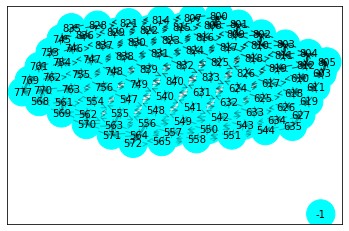

In [6]:
import matplotlib.pyplot as plt
ax, G = explainer.visualize_subgraph(-1, random_sample.edge_index, _edge_mask)

plt.rcParams["figure.figsize"] = (40,30)

plt.show()

In [7]:
print(_node_feat_mask.shape, _edge_mask.shape)
print(_node_feat_mask, _edge_mask)
random_sample

torch.Size([6]) torch.Size([4872])
tensor([0.1979, 0.2262, 0.8038, 0.8381, 0.6716, 0.3245], device='cuda:0') tensor([0.2769, 0.2907, 0.2789,  ..., 0.5091, 0.5122, 0.5160], device='cuda:0')


Data(edge_index=[2, 4872], face=[3, 1595], pos=[841, 3], x=[841, 6], y=1)

In [8]:
# for edge in edge_index.T:
# for edge, relevance in zip(edge_index.T, edge_mask):
# node_relevance[edge[0]] += relevance
# node_relevance[edge[1]] += relevance
# node_count[edge[0]] += 1
# node_count[edge[1]] += 1
# node_relevance =/ node_count
# meshio

In [9]:
node_relevance = [0 for i in range(random_sample.pos.shape[0])]
node_count = [*node_relevance]

random_sample = random_sample.to('cpu')
edge_index = random_sample.edge_index.numpy().T
nodes = random_sample.pos.numpy()

edge_mask = _edge_mask.to('cpu').numpy()

for edge, relevance in zip(edge_index, edge_mask):
    node_relevance[edge[0]] += relevance
    node_relevance[edge[1]] += relevance
    node_count[edge[0]] += 1
    node_count[edge[1]] += 1

for idx, count in enumerate(node_count):
    node_relevance[idx] /= count

In [10]:
import numpy as np

relevance_threshold = 0.3

faces = random_sample.face.numpy().T

node_mask = [0 if i > relevance_threshold else 1 for i in node_relevance]
face_mask = []

for i, (n1, n2, n3) in enumerate(faces):
    if (
        node_mask[n1] or
        node_mask[n2] or
        node_mask[n3]
    ):
        face_mask.append(i)
        
filtered_faces = np.delete(faces, face_mask, 0)
filtered_faces.shape, faces.shape

((564, 3), (1595, 3))

In [11]:
from utils.mesh import Mesh

mesh = Mesh(verts=nodes, connectivity=filtered_faces)
mesh.writeVTU(filename='random_sample.vtu')

/notebooks/utils/mesh.py:53: RuntimeWarning: invalid value encountered in true_divide
  self.normals[i, :] = n/np.linalg.norm(n)
